In [1]:
# for package auto reload
%load_ext autoreload
%autoreload 2

# for better rendering of plots in jupyter notebook
%matplotlib inline

In [2]:
from pathlib import Path
import IPython
import seaborn as sns
import re
import logging
import graphviz
from collections import OrderedDict
import numpy as np
import pandas as pd
import math
import dill
from sklearn.ensemble import RandomForestRegressor, BaggingRegressor, RandomForestClassifier
from sklearn.tree import DecisionTreeRegressor, plot_tree, export_graphviz, DecisionTreeClassifier
from sklearn import metrics
from sklearn.model_selection import cross_val_score, KFold, GridSearchCV
from sklearn.preprocessing import LabelEncoder
from sklearn.calibration import CalibratedClassifierCV
from sklearn.inspection import permutation_importance
from catboost import CatBoostRegressor, Pool, cv
from scipy.cluster import hierarchy
from matplotlib import pyplot as plt

In [3]:
from assproject.transforms import (
    add_date_columns, change_columns_from_str_to_categorical, process_df,process_df, split_vals,
)
from assproject.plot import draw_tree
from assproject.explain import rf_feat_importance, tree_feature_importance

In [4]:
#Locating the file location
path_to_last = Path('..').resolve()
path_to_data = path_to_last / "data"

In [9]:
df = pd.read_feather(path_to_data / 'transformed')

In [6]:
df = df.convert_dtypes()

In [10]:
df.dtypes

Batch_ID                          Int64
Beer_Style                         int8
SKU                                int8
Location                           int8
Fermentation_Time                 Int64
Temperature                     Float64
pH_Level                        Float64
Gravity                         Float64
Alcohol_Content                 Float64
Bitterness                        Int64
Color                             Int64
Volume_Produced                   Int64
Total_Sales                     Float64
Quality_Score                   Float64
Brewhouse_Efficiency            Float64
Loss_During_Brewing             Float64
Loss_During_Fermentation        Float64
Loss_During_Bottling_Kegging    Float64
Brew_Year                         int32
Brew_Month                        int32
Brew_Day                          int32
Brew_Dayofweek                    int32
Brew_Dayofyear                    int32
Brew_Is_month_start                bool
Brew_Is_month_end                  bool


In [8]:
df['Brew_Date'] = pd.to_datetime(df['Brew_Date'])

In [9]:
df.head(5)

Batch_ID           Brew_Date  Beer_Style   SKU      Location  \
0   7870796 2020-01-01 00:00:19  Wheat Beer  Kegs    Whitefield   
1   9810411 2020-01-01 00:00:31        Sour  Kegs    Whitefield   
2   2623342 2020-01-01 00:00:40  Wheat Beer  Kegs   Malleswaram   
3   8114651 2020-01-01 00:01:37         Ale  Kegs   Rajajinagar   
4   4579587 2020-01-01 00:01:43       Stout  Cans  Marathahalli   

   Fermentation_Time  Temperature  pH_Level   Gravity  Alcohol_Content  \
0                 16    24.204251  5.289845  1.039504         5.370842   
1                 13    18.086763  5.275643  1.059819         5.096053   
2                 12    15.539333  4.778016  1.037476         4.824737   
3                 17    16.418489  5.345261  1.052431         5.509243   
4                 18    19.144908  4.861854  1.054296         5.133625   

   Bitterness  Color Ingredient_Ratio  Volume_Produced   Total_Sales  \
0          20      5      1:0.32:0.16             4666   2664.759345   
1          36     14      1:0.39:0.24              832   9758.801062   
2          30     10      1:0.35:0.16             2115  11721.087016   
3          48     18      1:0.35:0.15             3173  12050.177463   
4          57     13      1:0.46:0.11             4449   5515.077465   

   Quality_Score  Brewhouse_Efficiency  Loss_During_Brewing  \
0       8.577016             89.195882             4.104988   
1       7.420541             72.480915             2.676528   
2       8.451365             86.322144             3.299894   
3       9.671859              83.09494             2.136055   
4       7.895334             88.625833             4.491724   

   Loss_During_Fermentation  Loss_During_Bottling_Kegging  
0                  3.235485                      4.663204  
1                  4.246129                      2.044358  
2                   3.10944                       3.03388  
3                  4.634254                      1.489889  
4                  2.183389                       2.99063

In [11]:
exclude = ["Ingredient_Ratio"]
all_col = df.columns.tolist()
feature_col = [col for col in all_col if col not in exclude]
feature_col

['Batch_ID',
 'Brew_Date',
 'Beer_Style',
 'SKU',
 'Location',
 'Fermentation_Time',
 'Temperature',
 'pH_Level',
 'Gravity',
 'Alcohol_Content',
 'Bitterness',
 'Color',
 'Volume_Produced',
 'Total_Sales',
 'Quality_Score',
 'Brewhouse_Efficiency',
 'Loss_During_Brewing',
 'Loss_During_Fermentation',
 'Loss_During_Bottling_Kegging']

In [12]:
df = df[feature_col]

In [15]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000000 entries, 0 to 9999999
Data columns (total 19 columns):
 #   Column                        Dtype         
---  ------                        -----         
 0   Batch_ID                      Int64         
 1   Brew_Date                     datetime64[ns]
 2   Beer_Style                    category      
 3   SKU                           category      
 4   Location                      category      
 5   Fermentation_Time             Int64         
 6   Temperature                   Float64       
 7   pH_Level                      Float64       
 8   Gravity                       Float64       
 9   Alcohol_Content               Float64       
 10  Bitterness                    Int64         
 11  Color                         Int64         
 12  Volume_Produced               Int64         
 13  Total_Sales                   Float64       
 14  Quality_Score                 Float64       
 15  Brewhouse_Efficiency          F

In [14]:
df = change_columns_from_str_to_categorical(df)

EDA

In [107]:
values = df['Beer_Style'].value_counts()

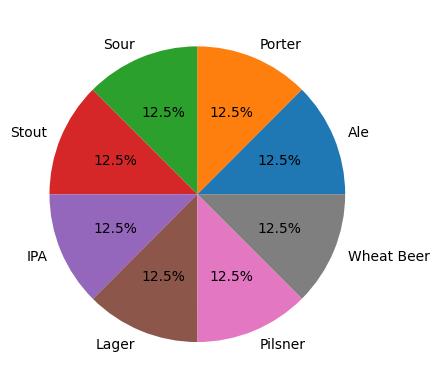

In [110]:
plt.pie(x=values,autopct='%.1f%%',labels=values.index)
plt.savefig('pie_chat.png',dpi=600)
plt.show()

In [112]:
values2 = df['Location'].value_counts()

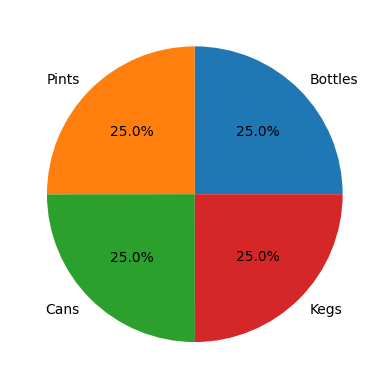

In [111]:
plt.pie(x=values2,autopct='%.1f%%',labels=values2.index)
plt.savefig('pie_chat2.png',dpi=600)
plt.show()

In [113]:
values3 = df['Location'].value_counts()

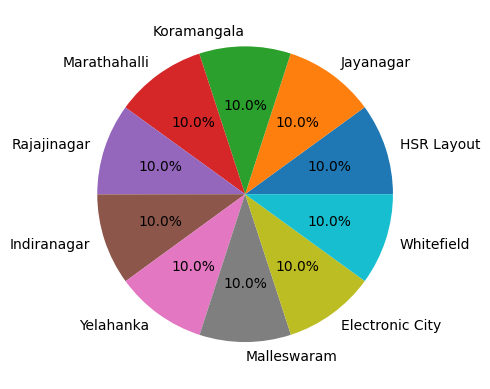

In [114]:
plt.pie(x=values3,autopct='%.1f%%',labels=values3.index)
plt.savefig('pie_chat3.png',dpi=600)
plt.show()

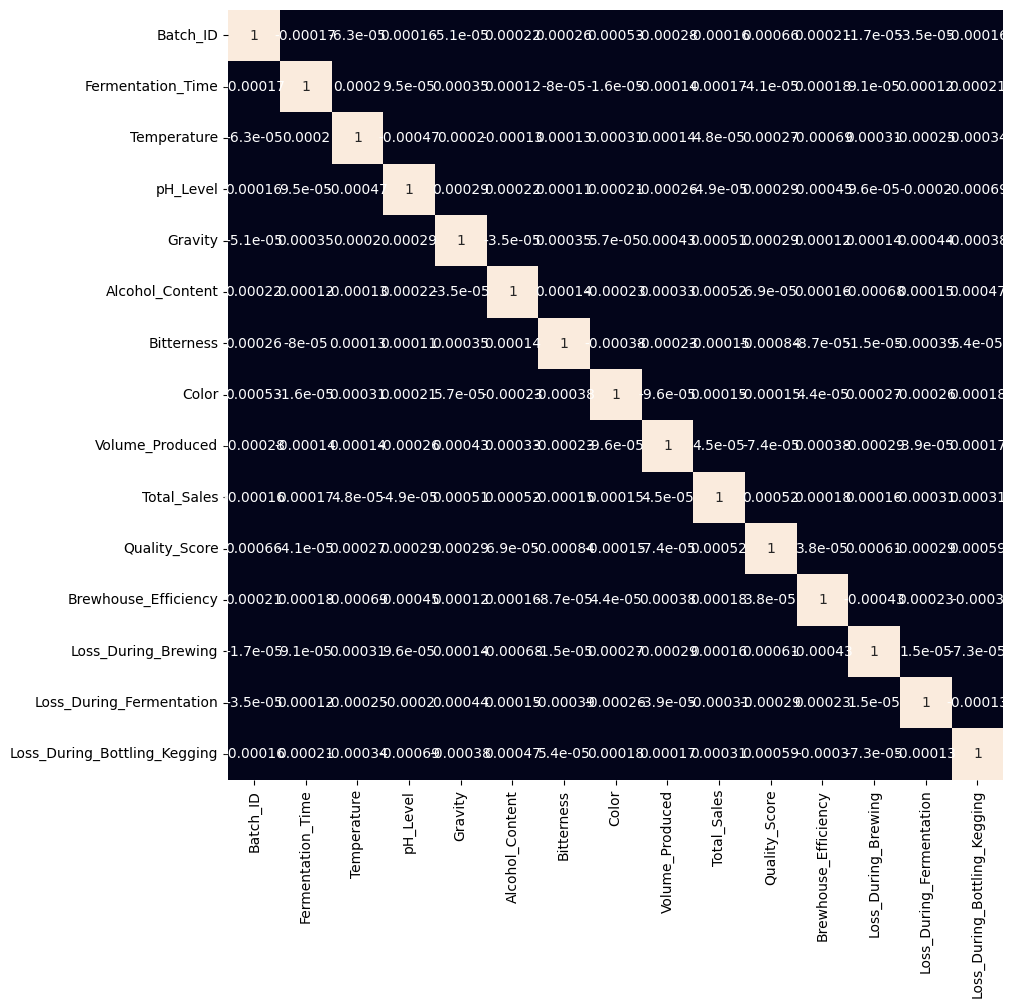

In [192]:
plt.figure(figsize=(10,10))
sns.heatmap(df.select_dtypes(include='number').corr(),annot=True,cbar=False)
plt.savefig('corr.png',dpi=600)

In [11]:
df['Total_Sales']

0           2664.759345
1           9758.801062
2          11721.087016
3          12050.177463
4           5515.077465
               ...     
9999995     6655.673836
9999996    10440.357817
9999997    17069.572855
9999998     5316.412808
9999999     8235.956266
Name: Total_Sales, Length: 10000000, dtype: Float64

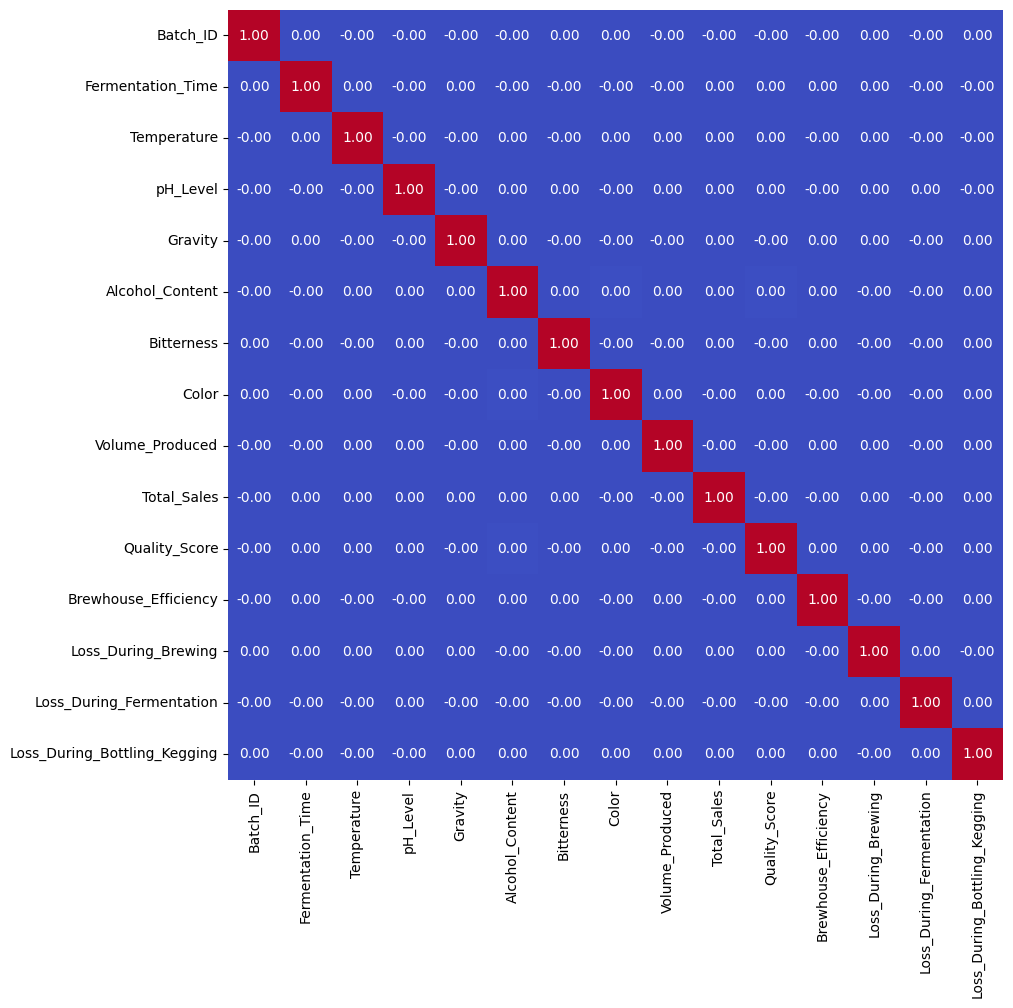

In [130]:
plt.figure(figsize=(10,10))
sns.heatmap(HSR.select_dtypes(include='number').corr(),annot=True,cbar=False,fmt=".2f",cmap="coolwarm")
plt.savefig('corr2.png',dpi=600)

In [12]:
#df = df.fillna(df.median())

In [13]:
df.columns

Index(['Batch_ID', 'Brew_Date', 'Beer_Style', 'SKU', 'Location',
       'Fermentation_Time', 'Temperature', 'pH_Level', 'Gravity',
       'Alcohol_Content', 'Bitterness', 'Color', 'Ingredient_Ratio',
       'Volume_Produced', 'Total_Sales', 'Quality_Score',
       'Brewhouse_Efficiency', 'Loss_During_Brewing',
       'Loss_During_Fermentation', 'Loss_During_Bottling_Kegging'],
      dtype='object')

In [39]:
def display_all(df):
    with pd.option_context("display.max_rows", 1000, "display.max_columns", 1000): 
        display(df)
df.shape

(10000000, 19)

In [15]:
#195 rows *880 columns
display_all(df.head().T)

0                    1  \
Batch_ID                                  7870796              9810411   
Brew_Date                     2020-01-01 00:00:19  2020-01-01 00:00:31   
Beer_Style                             Wheat Beer                 Sour   
SKU                                          Kegs                 Kegs   
Location                               Whitefield           Whitefield   
Fermentation_Time                              16                   13   
Temperature                             24.204251            18.086763   
pH_Level                                 5.289845             5.275643   
Gravity                                  1.039504             1.059819   
Alcohol_Content                          5.370842             5.096053   
Bitterness                                     20                   36   
Color                                           5                   14   
Ingredient_Ratio                      1:0.32:0.16          1:0.39:0.24   
Volume_Produced                              4666                  832   
Total_Sales                           2664.759345          9758.801062   
Quality_Score                            8.577016             7.420541   
Brewhouse_Efficiency                    89.195882            72.480915   
Loss_During_Brewing                      4.104988             2.676528   
Loss_During_Fermentation                 3.235485             4.246129   
Loss_During_Bottling_Kegging             4.663204             2.044358   

                                                2                    3  \
Batch_ID                                  2623342              8114651   
Brew_Date                     2020-01-01 00:00:40  2020-01-01 00:01:37   
Beer_Style                             Wheat Beer                  Ale   
SKU                                          Kegs                 Kegs   
Location                              Malleswaram          Rajajinagar   
Fermentation_Time                              12                   17   
Temperature                             15.539333            16.418489   
pH_Level                                 4.778016             5.345261   
Gravity                                  1.037476             1.052431   
Alcohol_Content                          4.824737             5.509243   
Bitterness                                     30                   48   
Color                                          10                   18   
Ingredient_Ratio                      1:0.35:0.16          1:0.35:0.15   
Volume_Produced                              2115                 3173   
Total_Sales                          11721.087016         12050.177463   
Quality_Score                            8.451365             9.671859   
Brewhouse_Efficiency                    86.322144             83.09494   
Loss_During_Brewing                      3.299894             2.136055   
Loss_During_Fermentation                  3.10944             4.634254   
Loss_During_Bottling_Kegging              3.03388             1.489889   

                                                4  
Batch_ID                                  4579587  
Brew_Date                     2020-01-01 00:01:43  
Beer_Style                                  Stout  
SKU                                          Cans  
Location                             Marathahalli  
Fermentation_Time                              18  
Temperature                             19.144908  
pH_Level                                 4.861854  
Gravity                                  1.054296  
Alcohol_Content                          5.133625  
Bitterness                                     57  
Color                                          13  
Ingredient_Ratio                      1:0.46:0.11  
Volume_Produced                              4449  
Total_Sales                           5515.077465  
Quality_Score                            7.895334  
Brewhouse_Efficiency                    88.625833  
Lo

In [16]:
display_all(df.describe(include = 'all').T)

count   unique                  top  \
Batch_ID                      10000000.0     <NA>                 <NA>   
Brew_Date                       10000000  9614455  2022-05-29 06:50:13   
Beer_Style                      10000000        8                  Ale   
SKU                             10000000        4              Bottles   
Location                        10000000       10           HSR Layout   
Fermentation_Time             10000000.0     <NA>                 <NA>   
Temperature                   10000000.0     <NA>                 <NA>   
pH_Level                      10000000.0     <NA>                 <NA>   
Gravity                       10000000.0     <NA>                 <NA>   
Alcohol_Content               10000000.0     <NA>                 <NA>   
Bitterness                    10000000.0     <NA>                 <NA>   
Color                         10000000.0     <NA>                 <NA>   
Ingredient_Ratio                10000000      651          1:0.21:0.27   
Volume_Produced               10000000.0     <NA>                 <NA>   
Total_Sales                   10000000.0     <NA>                 <NA>   
Quality_Score                 10000000.0     <NA>                 <NA>   
Brewhouse_Efficiency          10000000.0     <NA>                 <NA>   
Loss_During_Brewing           10000000.0     <NA>                 <NA>   
Loss_During_Fermentation      10000000.0     <NA>                 <NA>   
Loss_During_Bottling_Kegging  10000000.0     <NA>                 <NA>   

                                 freq          mean             std  \
Batch_ID                         <NA>     4999999.5  2886751.490286   
Brew_Date                           5           NaN             NaN   
Beer_Style                    1251002           NaN             NaN   
SKU                           2501597           NaN             NaN   
Location                      1000789           NaN             NaN   
Fermentation_Time                <NA>     14.500898        2.872006   
Temperature                      <NA>     19.999899         2.88703   
pH_Level                         <NA>      4.999941        0.288638   
Gravity                          <NA>      1.055003        0.014435   
Alcohol_Content                  <NA>      5.249709        0.432961   
Bitterness                       <NA>       39.4962       11.545572   
Color                            <NA>     11.999346         4.32117   
Ingredient_Ratio                17040           NaN             NaN   
Volume_Produced                  <NA>   2749.030959     1299.078133   
Total_Sales                      <NA>  10497.785344     5485.995545   
Quality_Score                    <NA>      7.999825        1.154679   
Brewhouse_Efficiency             <NA>     80.000919         5.77493   
Loss_During_Brewing              <NA>      3.000081        1.154748   
Loss_During_Fermentation         <NA>      3.000002        1.154827   
Loss_During_Bottling_Kegging     <NA>      3.000159        1.154719   

                                      min          25%          50%  \
Batch_ID                              0.0   2499999.75    4999999.5   
Brew_Date                             NaN          NaN          NaN   
Beer_Style                            NaN          NaN          NaN   
SKU                                   NaN          NaN          NaN   
Location                              NaN          NaN          NaN   
Fermentation_Time                    10.0         12.0         15.0   
Temperature                     15.000001    17.499842    19.999771   
pH_Level                              4.5      4.75004     4.999885   
Gravity                              1.03     1.042502     1.055004   
Alcohol_Content                       4.5     4.874663     5.249849   
Bitterness                           20.0         29.0         39.0   
Color                                 5.0          8.0         12.0   
Ingredient_Ratio                      NaN          NaN          N

In [9]:
df["Brew_Date"] =df["Brew_Date"].astype("datetime64[ns]")


In [10]:
df["Brew_Date"] =pd.to_datetime(df["Brew_Date"])
df["Brew_Date"] = df["Brew_Date"].apply(lambda t: t.timestamp())

In [11]:
df["Brew_Date"]

0          1.577837e+09
1          1.577837e+09
2          1.577837e+09
3          1.577837e+09
4          1.577837e+09
               ...     
9999995    1.704067e+09
9999996    1.704067e+09
9999997    1.704067e+09
9999998    1.704067e+09
9999999    1.704067e+09
Name: Brew_Date, Length: 10000000, dtype: float64

In [16]:
nas = df.isnull().sum()
x = df.drop('Quality_Score', axis = 1)
y = df['Quality_Score']
print(nas)
#y is target value, nas is missing value records, x is eigenvalue set.

Batch_ID                        0
Brew_Date                       0
Beer_Style                      0
SKU                             0
Location                        0
Fermentation_Time               0
Temperature                     0
pH_Level                        0
Gravity                         0
Alcohol_Content                 0
Bitterness                      0
Color                           0
Volume_Produced                 0
Total_Sales                     0
Quality_Score                   0
Brewhouse_Efficiency            0
Loss_During_Brewing             0
Loss_During_Fermentation        0
Loss_During_Bottling_Kegging    0
dtype: int64


In [13]:
a = df.select_dtypes(include=['category']).columns

In [14]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000000 entries, 0 to 9999999
Data columns (total 20 columns):
 #   Column                        Dtype   
---  ------                        -----   
 0   Batch_ID                      Int64   
 1   Brew_Date                     float64 
 2   Beer_Style                    category
 3   SKU                           category
 4   Location                      category
 5   Fermentation_Time             Int64   
 6   Temperature                   Float64 
 7   pH_Level                      Float64 
 8   Gravity                       Float64 
 9   Alcohol_Content               Float64 
 10  Bitterness                    Int64   
 11  Color                         Int64   
 12  Ingredient_Ratio              category
 13  Volume_Produced               Int64   
 14  Total_Sales                   Float64 
 15  Quality_Score                 Float64 
 16  Brewhouse_Efficiency          Float64 
 17  Loss_During_Brewing           Float64 
 18  L

In [19]:
df.Brew_Date.dt

In [10]:
df = pd.get_dummies(df, columns=a, drop_first=True)

In [22]:
df_transformed = add_date_columns(df, fields = ['Brew_Date'])

In [26]:
df_transformed.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000000 entries, 0 to 9999999
Data columns (total 30 columns):
 #   Column                        Dtype   
---  ------                        -----   
 0   Batch_ID                      Int64   
 1   Beer_Style                    category
 2   SKU                           category
 3   Location                      category
 4   Fermentation_Time             Int64   
 5   Temperature                   Float64 
 6   pH_Level                      Float64 
 7   Gravity                       Float64 
 8   Alcohol_Content               Float64 
 9   Bitterness                    Int64   
 10  Color                         Int64   
 11  Volume_Produced               Int64   
 12  Total_Sales                   Float64 
 13  Quality_Score                 Float64 
 14  Brewhouse_Efficiency          Float64 
 15  Loss_During_Brewing           Float64 
 16  Loss_During_Fermentation      Float64 
 17  Loss_During_Bottling_Kegging  Float64 
 18  B

In [28]:
df_transformed.Beer_Style.cat.categories.tolist()

['Ale', 'IPA', 'Lager', 'Pilsner', 'Porter', 'Sour', 'Stout', 'Wheat Beer']

In [78]:
df_transformed.Location

0          8
1          8
2          5
3          7
4          6
          ..
9999995    9
9999996    0
9999997    5
9999998    0
9999999    0
Name: Location, Length: 10000000, dtype: int8

In [33]:
df_transformed.Beer_Style = df_transformed.Beer_Style.cat.set_categories(['Ale', 'IPA', 'Lager', 'Pilsner', 'Porter', 'Sour', 'Stout',
                  'Wheat Beer'], ordered = True)
df_transformed.SKU = df_transformed.SKU.cat.set_categories(['Bottles', 'Cans', 'Kegs', 'Pints'], ordered = True)
df_transformed.Location = df_transformed.Location.cat.set_categories(['Electronic City', 'HSR Layout', 'Indiranagar', 'Jayanagar',
                  'Koramangala', 'Malleswaram', 'Marathahalli', 'Rajajinagar',
                  'Whitefield', 'Yelahanka'], ordered = True)

In [36]:
df_transformed.Beer_Style = df_transformed.Beer_Style.cat.codes
df_transformed.SKU = df_transformed.SKU.cat.codes
df_transformed.Location = df_transformed.Location.cat.codes

In [37]:
df_transformed.Beer_Style

0          7
1          5
2          7
3          0
4          6
          ..
9999995    6
9999996    7
9999997    1
9999998    0
9999999    7
Name: Beer_Style, Length: 10000000, dtype: int8

In [40]:
display_all(df_transformed.isnull().sum().sort_index()/len(df_transformed))

Alcohol_Content                 0.0
Batch_ID                        0.0
Beer_Style                      0.0
Bitterness                      0.0
Brew_Day                        0.0
Brew_Dayofweek                  0.0
Brew_Dayofyear                  0.0
Brew_Elapsed                    0.0
Brew_Is_month_end               0.0
Brew_Is_month_start             0.0
Brew_Is_quarter_end             0.0
Brew_Is_quarter_start           0.0
Brew_Is_year_end                0.0
Brew_Is_year_start              0.0
Brew_Month                      0.0
Brew_Year                       0.0
Brewhouse_Efficiency            0.0
Color                           0.0
Fermentation_Time               0.0
Gravity                         0.0
Location                        0.0
Loss_During_Bottling_Kegging    0.0
Loss_During_Brewing             0.0
Loss_During_Fermentation        0.0
Quality_Score                   0.0
SKU                             0.0
Temperature                     0.0
Total_Sales                 

In [41]:
df_transformed.to_feather(path_to_data / 'transformed')

In [12]:
nas = df.isnull().sum()
x = df.drop('Quality_Score', axis = 1)
y = df['Quality_Score']
print(nas)

Batch_ID                        0
Beer_Style                      0
SKU                             0
Location                        0
Fermentation_Time               0
Temperature                     0
pH_Level                        0
Gravity                         0
Alcohol_Content                 0
Bitterness                      0
Color                           0
Volume_Produced                 0
Total_Sales                     0
Quality_Score                   0
Brewhouse_Efficiency            0
Loss_During_Brewing             0
Loss_During_Fermentation        0
Loss_During_Bottling_Kegging    0
Brew_Year                       0
Brew_Month                      0
Brew_Day                        0
Brew_Dayofweek                  0
Brew_Dayofyear                  0
Brew_Is_month_start             0
Brew_Is_month_end               0
Brew_Is_quarter_start           0
Brew_Is_quarter_end             0
Brew_Is_year_start              0
Brew_Is_year_end                0
Brew_Elapsed  

In [13]:
x = x.sample(frac=0.1, random_state=42)
y = y[x.index]

## RandomForestRegressor

In [63]:
model = RandomForestRegressor(n_estimators=50, n_jobs=-1, random_state=42)

%time model.fit(x, y)

CPU times: total: 35min 8s
Wall time: 2min 17s


RandomForestRegressor(n_estimators=50, n_jobs=-1, random_state=42)

In [64]:
y = y.reset_index(drop=True)

In [65]:
x = x.reset_index(drop=True)

In [66]:
y_true = np.exp(y[0])
#Inverse transformation for comparing the predicted value with the true target value

#first record of df and y

In [67]:
b = x.iloc[0]
b = pd.DataFrame([b])# wrap the data point into a list

In [68]:
y_pred = model.predict(b) # prediction, as list
y_pred = y_pred[0]        # take first element of predicted list
y_pred = np.exp(y_pred)   # exponentialize
y_pred

1155.958556843843

In [69]:
model.score(x, y)

0.8519149278422512

In [70]:
with open('RandomForest.pkl', 'wb') as file:
    dill.dump(model, file)

In [48]:
#to check whether or not the data lead to overfitting.

In [16]:
n_total = len(x)
n_valid = 50000  # same as Kaggle's test set size
n_train = n_total - n_valid
n_small = 20000

print('full number of data points : {}'.format(n_total))
print('number of validation data points : {}'.format(n_valid))
print('number of training data points : {}'.format(n_train))
#we dont have much sample, so we dont need subsampled training points

full number of data points : 1000000
number of validation data points : 50000
number of training data points : 950000


In [17]:
X_train, X_valid = split_vals(x, n_train)
y_train, y_valid = split_vals(y, n_train)

X_small, _ = split_vals(X_train, n_small)
y_small, _ = split_vals(y_train, n_small)

print('Number of small training data points: X = {}, y = {}'.format(X_small.shape, y_small.shape))
print('Number of full training data points: X = {}, y = {}'.format(X_train.shape, y_train.shape))
print('Number of validation data points: X = {}, y = {}'.format(X_valid.shape, y_valid.shape))

Number of small training data points: X = (20000, 29), y = (20000,)
Number of full training data points: X = (950000, 29), y = (950000,)
Number of validation data points: X = (50000, 29), y = (50000,)


In [18]:
def rmse(y_gold, y_pred): 
    return math.sqrt(((y_gold - y_pred)**2).mean())

In [19]:
def print_score(m, X_train, y_train, X_valid, y_valid):
    print('RMSE on train set: {:.4f}'.format(rmse(m.predict(X_train), y_train)))
    print('RMSE on valid set: {:.4f}'.format(rmse(m.predict(X_valid), y_valid)))
    print('R^2 on train set: {:.4f}'.format(m.score(X_train, y_train)))
    print('R^2 on valid set: {:.4f}'.format(m.score(X_valid, y_valid)))
    if hasattr(m, 'oob_score_'): print('R^2 on oob set: {:.4f}'.format(m.oob_score_))
    return

In [20]:
base_model = RandomForestRegressor(n_estimators = 10, n_jobs = -1, random_state = 42)

%time base_model.fit(X_small, y_small)
print_score(base_model, X_small, y_small, X_valid, y_valid)

CPU times: total: 15.2 s
Wall time: 3.01 s
RMSE on train set: 0.5150
RMSE on valid set: 1.2232
R^2 on train set: 0.8019
R^2 on valid set: -0.1166


## NOT GOOD

## Decision Tree

In [21]:
model_dt = DecisionTreeRegressor(
    criterion = 'squared_error',
    splitter = 'best', 
    max_depth = 15,
    min_samples_split = 2, 
    min_samples_leaf = 1,
    min_weight_fraction_leaf = 0.0, 
    max_features = None, 
    max_leaf_nodes = None, 
    min_impurity_decrease = 0.0001, 
    ccp_alpha = 0.0,
    random_state = 42,
)

In [80]:
model_dt.fit(X_valid, y_valid)
print_score(model_dt, X_valid, y_valid, X_train, y_train)

RMSE on train set: 0.9905
RMSE on valid set: 1.3009
R^2 on train set: 0.2649
R^2 on valid set: -0.2694


In [81]:
model_dt.score(X_valid, y_valid)

0.26492529296411793

[Text(0.618973376125725, 0.96875, 'x[0] <= 7828245.0\nsquared_error = 1.335\nsamples = 20000\nvalue = 7.971'),
 Text(0.40838418706115803, 0.90625, 'x[21] <= 336.5\nsquared_error = 1.333\nsamples = 15652\nvalue = 7.956'),
 Text(0.5136787815934415, 0.9375, 'True  '),
 Text(0.3046676249109596, 0.84375, 'x[0] <= 7310534.0\nsquared_error = 1.335\nsamples = 14394\nvalue = 7.946'),
 Text(0.23663996514704386, 0.78125, 'x[11] <= 4898.5\nsquared_error = 1.337\nsamples = 13442\nvalue = 7.954'),
 Text(0.20127423170855804, 0.71875, 'x[6] <= 5.467\nsquared_error = 1.34\nsamples = 13188\nvalue = 7.95'),
 Text(0.16871565584613818, 0.65625, 'x[6] <= 5.458\nsquared_error = 1.341\nsamples = 12779\nvalue = 7.945'),
 Text(0.13777729724229165, 0.59375, 'x[0] <= 7293097.5\nsquared_error = 1.341\nsamples = 12650\nvalue = 7.948'),
 Text(0.10215477765340389, 0.53125, 'x[1] <= 1.5\nsquared_error = 1.341\nsamples = 12618\nvalue = 7.947'),
 Text(0.055637529256131066, 0.46875, 'x[8] <= 4.925\nsquared_error = 1.35\n

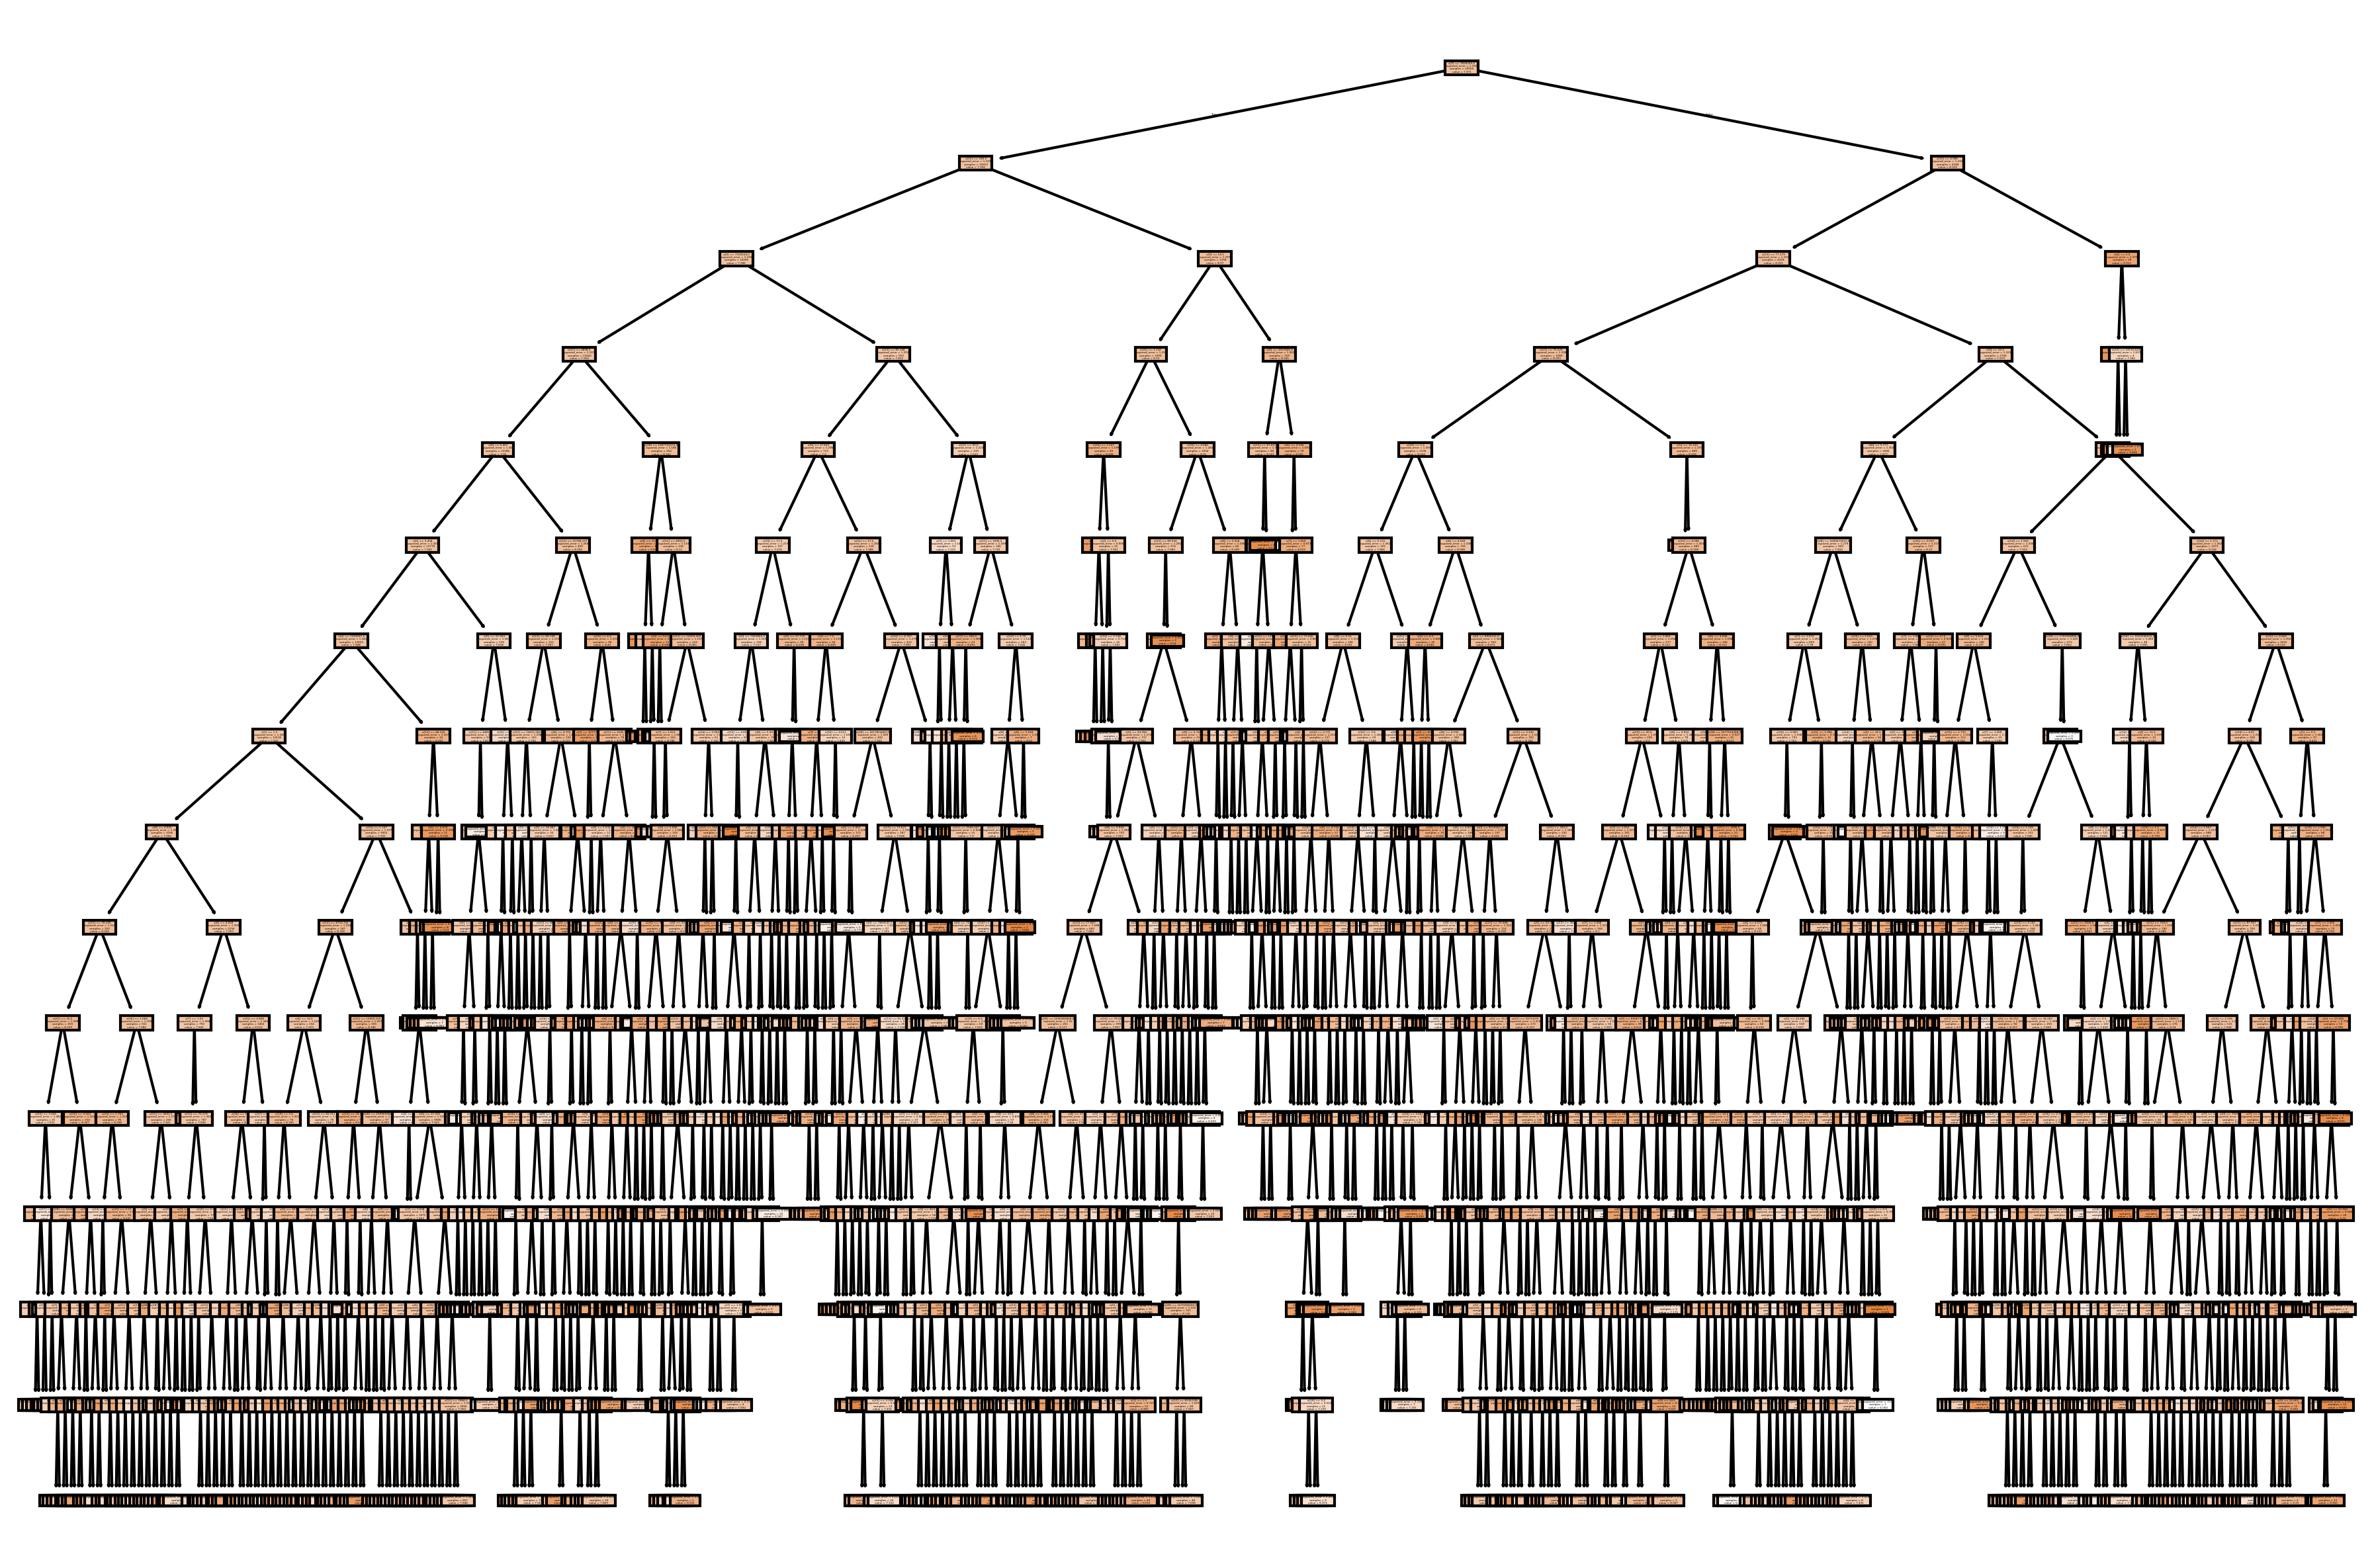

In [82]:
fig, axes = plt.subplots(nrows = 1, ncols = 1, figsize = (15, 10), dpi = 300)
plot_tree(model_dt, filled = True)

[Text(0.618973376125725, 0.96875, 'x[0] <= 7828245.0\nsquared_error = 1.335\nsamples = 20000\nvalue = 7.971'),
 Text(0.40838418706115803, 0.90625, 'x[21] <= 336.5\nsquared_error = 1.333\nsamples = 15652\nvalue = 7.956'),
 Text(0.5136787815934415, 0.9375, 'True  '),
 Text(0.3046676249109596, 0.84375, 'x[0] <= 7310534.0\nsquared_error = 1.335\nsamples = 14394\nvalue = 7.946'),
 Text(0.23663996514704386, 0.78125, 'x[11] <= 4898.5\nsquared_error = 1.337\nsamples = 13442\nvalue = 7.954'),
 Text(0.20127423170855804, 0.71875, 'x[6] <= 5.467\nsquared_error = 1.34\nsamples = 13188\nvalue = 7.95'),
 Text(0.16871565584613818, 0.65625, 'x[6] <= 5.458\nsquared_error = 1.341\nsamples = 12779\nvalue = 7.945'),
 Text(0.13777729724229165, 0.59375, 'x[0] <= 7293097.5\nsquared_error = 1.341\nsamples = 12650\nvalue = 7.948'),
 Text(0.10215477765340389, 0.53125, 'x[1] <= 1.5\nsquared_error = 1.341\nsamples = 12618\nvalue = 7.947'),
 Text(0.055637529256131066, 0.46875, 'x[8] <= 4.925\nsquared_error = 1.35\n

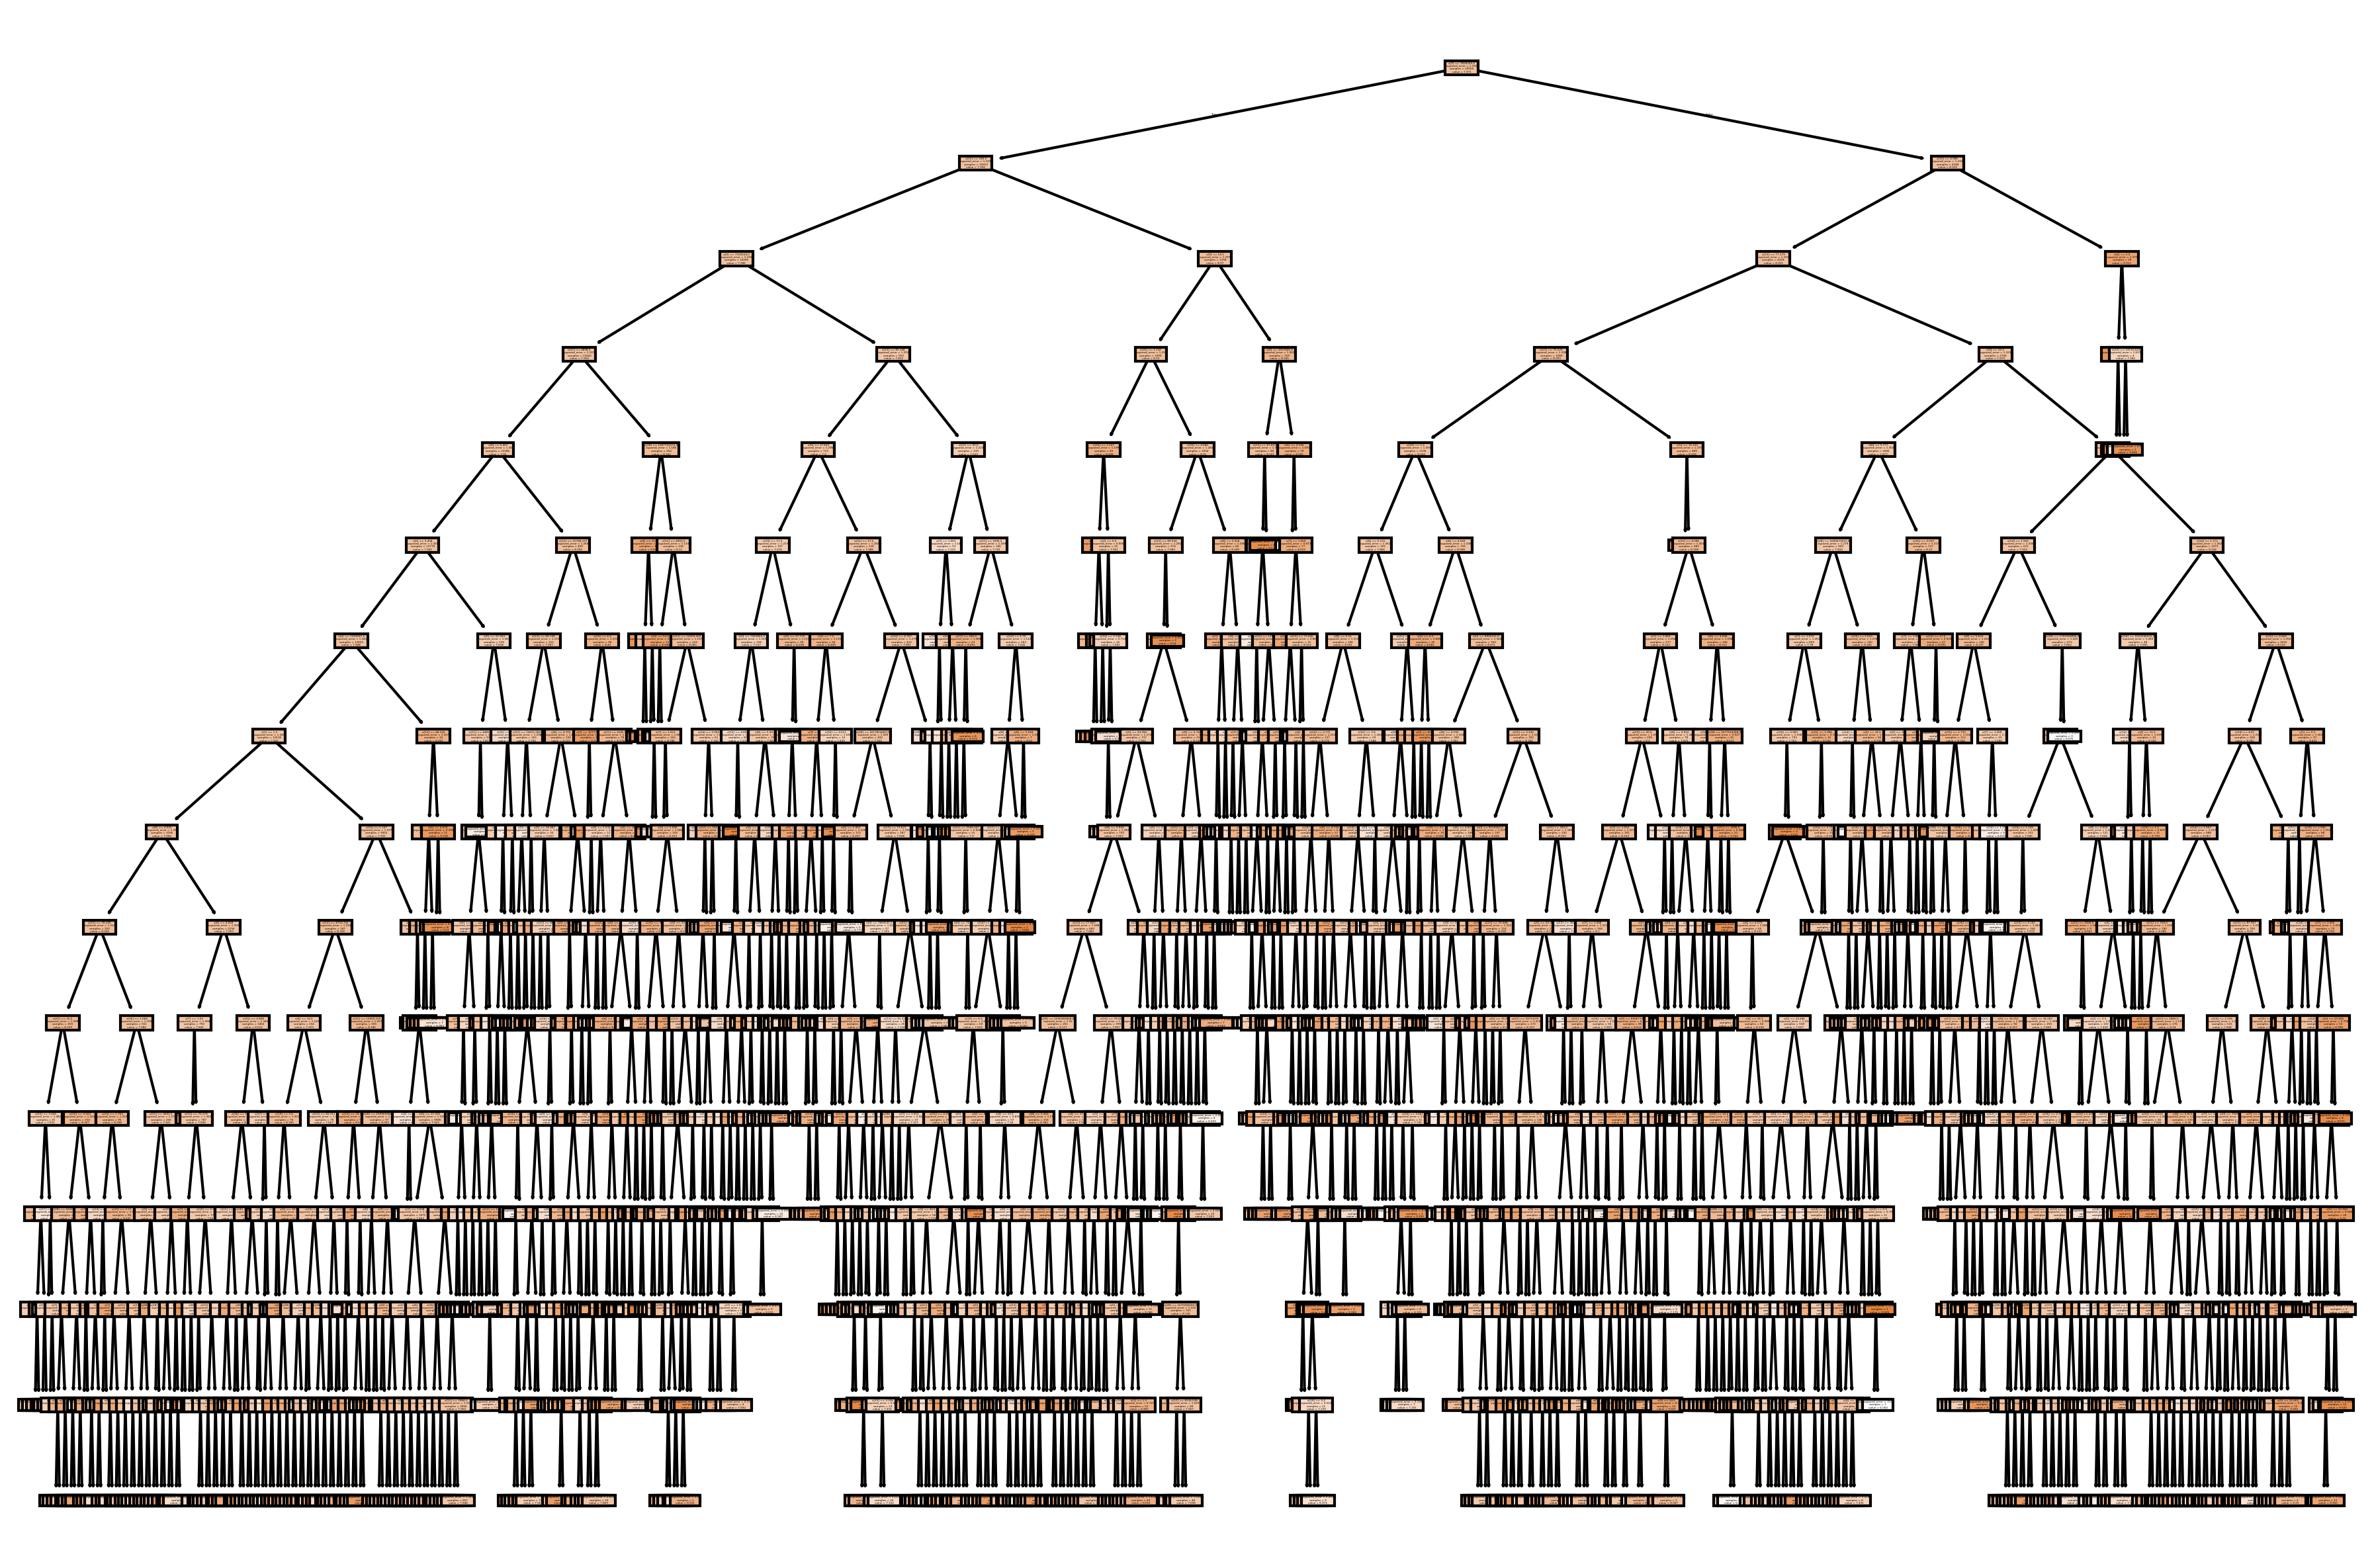

In [83]:
fig, axes = plt.subplots(nrows = 1, ncols = 1, figsize = (15, 10), dpi = 300)
plot_tree(model_dt, filled = True)

In [84]:
draw_tree(model_dt, feature_names = X_valid.columns.tolist(),size = 15, ratio = 0.6, precision = 3)

In [85]:
draw_tree(model_dt, feature_names = X_valid.columns.tolist(),size = 15, ratio = 0.6, precision = 3)

Tree Bagging

In [22]:
base_model = RandomForestRegressor(
    # parameters shared with DecisionTreeRegressor
    n_estimators = 300, # 100 # 1 = the model is a single tree
    criterion = 'squared_error', 
    max_depth = 20,
    min_samples_split = 2, 
    min_samples_leaf = 1,
    min_weight_fraction_leaf = 0.0, 
    max_features = None, 
    max_leaf_nodes = None, 
    min_impurity_decrease = 0.0,
    ccp_alpha = 0.0, 
    random_state = 42,
    
    # RandomForestRegressor specific hyperparameters
    bootstrap = True,
    oob_score = False, 
    max_samples = None,

    # extra parameters
    warm_start = False, 
    n_jobs = -1,
    verbose = 0, 
)

%time base_model.fit(X_small, y_small)
print_score(base_model, X_small, y_small, X_valid, y_valid)

CPU times: total: 9min 28s
Wall time: 32.5 s
RMSE on train set: 0.7971
RMSE on valid set: 1.1618
R^2 on train set: 0.5255
R^2 on valid set: -0.0074


In [88]:
base_model = RandomForestRegressor(
    # parameters shared with DecisionTreeRegressor
    n_estimators = 300, # 100 # 1 = the model is a single tree
    criterion = 'squared_error', 
    max_depth = 10,
    min_samples_split = 2, 
    min_samples_leaf = 1,
    min_weight_fraction_leaf = 0.0, 
    max_features = None, 
    max_leaf_nodes = None, 
    min_impurity_decrease = 0.0,
    ccp_alpha = 0.0, 
    random_state = 42,
    
    # RandomForestRegressor specific hyperparameters
    bootstrap = False,
    oob_score = False, 
    max_samples = None,

    # extra parameters
    warm_start = False, 
    n_jobs = -1,
    verbose = 0, 
)

%time base_model.fit(X_small, y_small)
print_score(base_model, X_small, y_small, X_valid, y_valid)

CPU times: total: 8min 22s
Wall time: 36.3 s
RMSE on train set: 1.1299
RMSE on valid set: 1.1724
R^2 on train set: 0.0309
R^2 on valid set: -0.0300


In [23]:
point = X_valid.iloc[0,:]
print(point)

y_valid = y_valid.reset_index(drop=True)
price = y_valid[0]
print(price, np.exp(price))

Batch_ID                              806897
Beer_Style                                 6
SKU                                        0
Location                                   2
Fermentation_Time                         12
Temperature                        15.750996
pH_Level                            5.177221
Gravity                             1.055375
Alcohol_Content                     5.287095
Bitterness                                58
Color                                      7
Volume_Produced                         1886
Total_Sales                     12499.622296
Brewhouse_Efficiency               82.504244
Loss_During_Brewing                 2.734715
Loss_During_Fermentation            4.225944
Loss_During_Bottling_Kegging        1.319349
Brew_Year                               2023
Brew_Month                                 5
Brew_Day                                  24
Brew_Dayofweek                             2
Brew_Dayofyear                           144
Brew_Is_mo

In [24]:
base_model.predict([point])

# the model returns a list, so we take the first element, and apply exponetial
np.exp(base_model.predict([point])[0])

D:\software\Anaconda\envs\EM-Assproject-2024-Zhongjie\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(
D:\software\Anaconda\envs\EM-Assproject-2024-Zhongjie\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


3009.4316859780697

In [25]:
# model prediction on single data point
trees = base_model
point = [X_valid.iloc[0, :]]
pred = trees.predict(point)

print('Type:', type(pred))
print('Shape:', pred.shape)
print('Value:', np.exp(pred[0]))

Type: <class 'numpy.ndarray'>
Shape: (1,)
Value: 3009.4316859780647


D:\software\Anaconda\envs\EM-Assproject-2024-Zhongjie\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


In [26]:
# first tree prediction on single data point
tree = base_model.estimators_[0] # chose between 0 and 9 since we have 10 estimators
point = [X_valid.iloc[0, :]]     # tree.predict takes an iterable of data points as input
pred = tree.predict(point)       # tree.predict returns a numpy tensor of predictions as output

print('Type:', type(pred))
print('Shape:', pred.shape)
print('Value:', np.exp(pred[0]))

Type: <class 'numpy.ndarray'>
Shape: (1,)
Value: 1411.2821365340567


In [27]:
# all tree predictions on single data point
trees = base_model.estimators_
point = [X_valid.iloc[0, :]]
preds = np.asarray([tree.predict(point) for tree in trees])

print('Type:', type(preds))
print('Shape:', preds.shape)
print('Value:', np.exp(preds))

Type: <class 'numpy.ndarray'>
Shape: (300, 1)
Value: [[ 1411.28213653]
 [ 6330.06373265]
 [ 2408.74648217]
 [ 3472.20381338]
 [ 1043.36951971]
 [ 2384.4205229 ]
 [ 2763.98665781]
 [ 4140.10329285]
 [  882.96570649]
 [ 4014.76530879]
 [ 1127.40116213]
 [11491.2296419 ]
 [ 1348.26735534]
 [ 2929.85238243]
 [ 3289.15654315]
 [ 1130.28639038]
 [ 3735.1106026 ]
 [ 3148.35984194]
 [10730.05415594]
 [ 3008.24985785]
 [ 5118.10851935]
 [ 4374.15091746]
 [ 8338.96900518]
 [  529.05713715]
 [ 3085.76076111]
 [ 6270.431217  ]
 [  442.95500158]
 [16101.73470207]
 [ 2922.71855698]
 [  542.79281613]
 [ 4821.57259842]
 [ 3384.16938124]
 [  885.7735498 ]
 [ 2516.05874526]
 [ 4613.29991491]
 [ 1247.03234867]
 [  460.20651126]
 [17488.11728913]
 [ 2562.06422302]
 [ 2423.95650589]
 [11734.12373374]
 [ 3022.66787623]
 [ 3267.16356981]
 [ 2869.23530492]
 [ 5608.08755241]
 [ 2888.55196283]
 [ 4976.51464334]
 [ 7852.71636458]
 [ 3316.92755943]
 [ 2917.9952919 ]
 [ 3028.78782888]
 [10523.96321284]
 [ 3944.519

In [28]:
# all tree predictions on all data
preds = np.stack([tree.predict(X_valid) for tree in base_model.estimators_]) # or np.asarray()

# predictions of the 10 trees, mean, and actual value (for first point in validation set)
preds[:,0], base_model.predict(point)[0], np.mean(preds[:,0]), y_valid[0]

D:\software\Anaconda\envs\EM-Assproject-2024-Zhongjie\Lib\site-packages\sklearn\base.py:486: UserWarning: X has feature names, but DecisionTreeRegressor was fitted without feature names
  warnings.warn(
D:\software\Anaconda\envs\EM-Assproject-2024-Zhongjie\Lib\site-packages\sklearn\base.py:486: UserWarning: X has feature names, but DecisionTreeRegressor was fitted without feature names
  warnings.warn(
D:\software\Anaconda\envs\EM-Assproject-2024-Zhongjie\Lib\site-packages\sklearn\base.py:486: UserWarning: X has feature names, but DecisionTreeRegressor was fitted without feature names
  warnings.warn(
D:\software\Anaconda\envs\EM-Assproject-2024-Zhongjie\Lib\site-packages\sklearn\base.py:486: UserWarning: X has feature names, but DecisionTreeRegressor was fitted without feature names
  warnings.warn(
D:\software\Anaconda\envs\EM-Assproject-2024-Zhongjie\Lib\site-packages\sklearn\base.py:486: UserWarning: X has feature names, but DecisionTreeRegressor was fitted without feature names
  

(array([7.25225389, 8.75306558, 7.78686176, 8.15254478, 6.95021068,
        7.77671141, 7.92442936, 8.32847602, 6.78328636, 8.29773417,
        7.02767041, 9.34933938, 7.20657561, 7.98270732, 8.09838644,
        7.03022632, 8.22553271, 8.05463691, 9.28080388, 8.00911375,
        8.54054022, 8.3834677 , 9.02869487, 6.27109644, 8.03455351,
        8.74360041, 6.09346819, 9.68668229, 7.98026947, 6.29672769,
        8.48085542, 8.12686377, 6.78646133, 7.83044897, 8.4366987 ,
        7.12852189, 6.13167533, 9.76927692, 7.84856855, 7.7931564 ,
        9.37025643, 8.01389512, 8.09167748, 7.96180083, 8.63196504,
        7.9685106 , 8.51248505, 8.96861478, 8.1067942 , 7.97865212,
        8.01591776, 9.26141015, 8.28008242, 8.29215659, 7.68615471,
        8.26983647, 8.26370012, 8.35853988, 8.03603854, 6.71202941,
        7.11719397, 9.31432908, 6.0345757 , 8.00826687, 9.44392526,
        9.23451079, 7.22664402, 8.38864148, 8.40606817, 7.25762777,
        6.07706061, 8.92182023, 7.95388557, 8.08

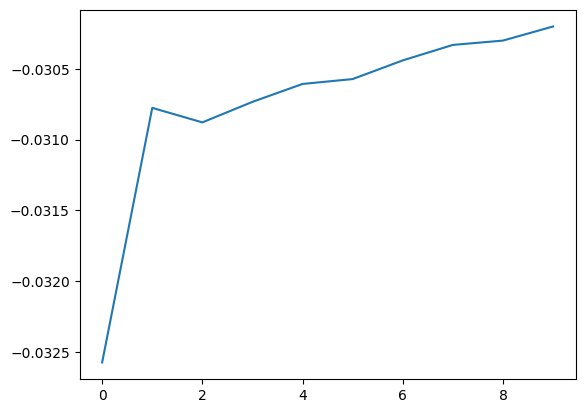

In [95]:
plt.plot([
    metrics.r2_score(y_valid, np.mean(preds[:num_trees], axis = 0)) 
    for num_trees in range(1, 11)
])

<Axes: ylabel='Density'>

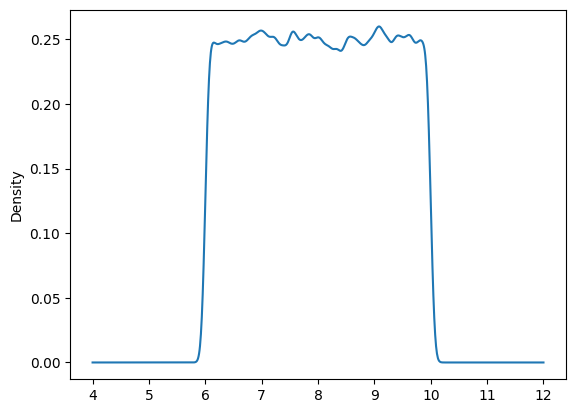

In [96]:
pd.Series(y_train).plot(kind = 'density', bw_method = 0.05)

In [97]:
len(X_train.columns)

29

In [98]:
model.feature_importances_

array([6.05535804e-02, 2.46208774e-02, 1.49668947e-02, 2.80586685e-02,
       2.78538496e-02, 5.98109451e-02, 5.96031437e-02, 5.95476864e-02,
       5.95930863e-02, 4.22128370e-02, 3.21422327e-02, 5.87574838e-02,
       5.96286453e-02, 5.98408226e-02, 6.00633319e-02, 5.94625284e-02,
       5.92920016e-02, 4.14541424e-03, 9.61008327e-03, 3.90870872e-02,
       2.30146788e-02, 4.22737114e-02, 7.20564277e-04, 9.40729573e-04,
       4.48532739e-04, 4.75480938e-04, 5.25022193e-05, 4.24605160e-05,
       5.31801395e-02])

In [99]:
tree = model.estimators_[0]

In [100]:
tree.tree_.compute_feature_importances(normalize = True)

array([6.21230779e-02, 2.59448013e-02, 1.47029493e-02, 2.80845397e-02,
       2.80212607e-02, 6.10123576e-02, 6.07425020e-02, 5.90606275e-02,
       5.97879274e-02, 4.59126487e-02, 3.22641263e-02, 6.04932561e-02,
       5.91656113e-02, 5.74468491e-02, 5.68115950e-02, 5.86578395e-02,
       5.89242286e-02, 4.16324271e-03, 1.12511472e-02, 3.84288943e-02,
       2.31758970e-02, 4.06239760e-02, 5.72249455e-04, 1.21261198e-03,
       6.15187717e-04, 4.77607227e-04, 2.74864083e-06, 1.05976195e-05,
       5.03096422e-02])

In [101]:
feat_importance = rf_feat_importance(tree, X_small)
feat_importance[:20]

cols       imp
0                       Batch_ID  0.062123
5                    Temperature  0.061012
6                       pH_Level  0.060743
11               Volume_Produced  0.060493
8                Alcohol_Content  0.059788
12                   Total_Sales  0.059166
7                        Gravity  0.059061
16  Loss_During_Bottling_Kegging  0.058924
15      Loss_During_Fermentation  0.058658
13          Brewhouse_Efficiency  0.057447
14           Loss_During_Brewing  0.056812
28                  Brew_Elapsed  0.050310
9                     Bitterness  0.045913
21                Brew_Dayofyear  0.040624
19                      Brew_Day  0.038429
10                         Color  0.032264
3                       Location  0.028085
4              Fermentation_Time  0.028021
1                     Beer_Style  0.025945
20                Brew_Dayofweek  0.023176

## Boosting

In [30]:
y.trans = np.log1p(y)

In [31]:
n_total = len(x)
n_valid = 50000  # same as Kaggle's test set size
n_train = n_total - n_valid
n_small = 20000

X_train, X_valid = split_vals(x, n_train)
y_train, y_valid = split_vals(y.trans, n_train)

X_small, _ = split_vals(x, n_small)
y_small, _ = split_vals(y.trans, n_small)

print(n_total)
print('Number of small training data points: X = {}, y = {}'.format(X_small.shape, y_small.shape))
print('Number of full training data points: X = {}, y = {}'.format(X_train.shape, y_train.shape))
print('Number of validation data points: X = {}, y = {}'.format(X_valid.shape, y_valid.shape))

1000000
Number of small training data points: X = (20000, 29), y = (20000,)
Number of full training data points: X = (950000, 29), y = (950000,)
Number of validation data points: X = (50000, 29), y = (50000,)


In [32]:
x.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1000000 entries, 919213 to 2187994
Data columns (total 29 columns):
 #   Column                        Non-Null Count    Dtype  
---  ------                        --------------    -----  
 0   Batch_ID                      1000000 non-null  Int64  
 1   Beer_Style                    1000000 non-null  int8   
 2   SKU                           1000000 non-null  int8   
 3   Location                      1000000 non-null  int8   
 4   Fermentation_Time             1000000 non-null  Int64  
 5   Temperature                   1000000 non-null  Float64
 6   pH_Level                      1000000 non-null  Float64
 7   Gravity                       1000000 non-null  Float64
 8   Alcohol_Content               1000000 non-null  Float64
 9   Bitterness                    1000000 non-null  Int64  
 10  Color                         1000000 non-null  Int64  
 11  Volume_Produced               1000000 non-null  Int64  
 12  Total_Sales                 

In [33]:
model = CatBoostRegressor(
    n_estimators = 5000,  # iterations, n_estimators, num_boost_round, num_trees
    learning_rate = 0.005, # learning_rate, eta,
    random_seed = 42,
    loss_function = 'RMSE',
    allow_writing_files = False,
    logging_level = 'Silent',
)

In [34]:
model.fit(X_small, y_small, plot = True)

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

In [ ]:
def rmse(y_gold, y_pred): 
    return math.sqrt(((y_gold - y_pred)**2).mean())


def print_score(m, X_train, y_train, X_valid, y_valid):
    print('RMSE on train set: {:.4f}'.format(rmse(m.predict(X_train), y_train)))
    print('RMSE on valid set: {:.4f}'.format(rmse(m.predict(X_valid), y_valid)))
    print('R^2 on train set: {:.4f}'.format(m.score(X_train, y_train)))
    print('R^2 on valid set: {:.4f}'.format(m.score(X_valid, y_valid)))
    if hasattr(m, 'oob_score_'): print('R^2 on oob set: {:.4f}'.format(m.oob_score_))
    return

In [35]:
print_score(model, X_small, y_small, X_valid, y_valid)

RMSE on train set: 0.1190
RMSE on valid set: 0.1308
R^2 on train set: 0.1640
R^2 on valid set: -0.0104


In [36]:
predictions = model.predict(X_valid.iloc[:10, :])

print(np.exp(y_valid[:10]))
print([int(np.exp(pred)) for pred in predictions])

8481033     7.758375
9695305     9.666431
4462419     7.355274
7590616     7.656982
9017715     9.485564
5308782     8.564461
8075022      8.63688
611441       7.00437
3907705    10.053397
6450026     8.708747
Name: Quality_Score, dtype: Float64
[9, 8, 9, 8, 8, 8, 8, 9, 8, 8]


In [37]:
print("Predicted values:", predictions)
print("True values:", y_valid.iloc[:10])

Predicted values: [2.20027155 2.19161772 2.1998072  2.17779842 2.18948295 2.17783028
 2.18533672 2.21106304 2.18657323 2.1535059 ]
True values: 8481033    2.048773
9695305    2.268659
4462419    1.995418
7590616    2.035618
9017715    2.249771
5308782    2.147621
8075022    2.156041
611441     1.946534
3907705    2.307911
6450026    2.164328
Name: Quality_Score, dtype: Float64


In [38]:
importances = model.feature_importances_
importances

array([5.71989574, 2.62732937, 1.90674736, 3.30392835, 2.31526947,
       6.05653323, 5.76419988, 5.41735887, 5.83381427, 5.58166065,
       3.40003647, 6.37441904, 5.45392923, 5.81773954, 5.77318327,
       5.5735194 , 5.3961995 , 0.92951814, 1.17731394, 3.79542301,
       2.82569123, 3.83130014, 0.21671219, 0.16865408, 0.07060879,
       0.02720174, 0.01458905, 0.00698644, 4.6202376 ])

In [39]:
y_valid.head(10)

8481033    2.048773
9695305    2.268659
4462419    1.995418
7590616    2.035618
9017715    2.249771
5308782    2.147621
8075022    2.156041
611441     1.946534
3907705    2.307911
6450026    2.164328
Name: Quality_Score, dtype: Float64

## Hyperparameter tuning

In [41]:
param_grid = [
    {'min_data_in_leaf': [2, 10, 50],        # equivalent of scikit-learn's 'min_samples_leaf'
     'colsample_bylevel': [0.5, 0.75], # equivalent of scikit-learn's max_features
     'subsample': [0.25, 0.5, 1],             # equivalent of scikit-learn's max_samples 
    },
]

In [65]:
grid = GridSearchCV(
    estimator = model, 
    param_grid = param_grid, 
    scoring = None, # uses estimator's default score method
    refit = True, # keep a fitted version of the overall best model
    cv = 5, 
    return_train_score = True,
    verbose = 2,
    n_jobs = -1, 
)

grid.fit(X_small, y_small)

Fitting 5 folds for each of 18 candidates, totalling 90 fits


GridSearchCV(cv=5,
             estimator=<catboost.core.CatBoostRegressor object at 0x000002355F4EB2D0>,
             n_jobs=-1,
             param_grid=[{'colsample_bylevel': [0.5, 0.75],
                          'min_data_in_leaf': [2, 10, 50],
                          'subsample': [0.25, 0.5, 1]}],
             return_train_score=True, verbose=2)

In [66]:
best_model = grid.best_estimator_
best_model

In [67]:
params = best_model.get_all_params()

print('min_data_in_leaf:', params['min_data_in_leaf'])
print('subsample:', params['subsample'])

min_data_in_leaf: 2
subsample: 0.25


In [68]:
cv = KFold(n_splits = 5, shuffle = True, random_state = 42)

scores = cross_val_score(best_model, X_small, y_small, cv = cv, n_jobs = -1)

print(scores)
print("r2 is {:.3f} with a standard deviation of {:.3f}".format(scores.mean(), scores.std()))

[-0.00498537 -0.01268613 -0.01026364 -0.00353036 -0.0102759 ]
r2 is -0.008 with a standard deviation of 0.003


In [69]:
train_pool = Pool(X_train, y_train)

feature_importances = model.get_feature_importance(train_pool)
feature_names = X_train.columns
for score, name in sorted(zip(feature_importances, feature_names), reverse = True):
    print('{}: {}'.format(name, score))

Volume_Produced: 6.423322442585886
Temperature: 6.0842609382428385
Alcohol_Content: 5.780652428497618
Brewhouse_Efficiency: 5.780551682225634
Loss_During_Brewing: 5.7532667952576855
pH_Level: 5.740719163125263
Batch_ID: 5.691125792146248
Loss_During_Fermentation: 5.566485396370576
Bitterness: 5.560119479685066
Total_Sales: 5.540050991020409
Gravity: 5.409796863340654
Loss_During_Bottling_Kegging: 5.367838329716777
Brew_Elapsed: 4.623838544237183
Brew_Dayofyear: 3.8402956707978007
Brew_Day: 3.8158122043098213
Color: 3.4169801529939243
Location: 3.2869613590659887
Brew_Dayofweek: 2.846080334148975
Beer_Style: 2.622720239326354
Fermentation_Time: 2.30907144652724
SKU: 1.9226196265944162
Brew_Month: 1.1900974111750153
Brew_Year: 0.9302901525832613
Brew_Is_month_start: 0.21355903819712144
Brew_Is_month_end: 0.1774951885687841
Brew_Is_quarter_start: 0.061006546517451375
Brew_Is_quarter_end: 0.026095491291453183
Brew_Is_year_start: 0.013431433756974571
Brew_Is_year_end: 0.0054548576936229946


## classification regression

These Feature can't provide to much predictive power

## Classification

In [43]:
n_total = len(x)
n_valid = 50000
n_train = n_total - n_valid
n_small = 20000

X_train, X_valid = split_vals(x, n_train)
y_train, y_valid = split_vals(y, n_train)

X_small, _ = split_vals(x, n_small)
y_small, _ = split_vals(y, n_small)

print('Number of small training data points: X = {}, y = {}'.format(X_small.shape, y_small.shape))
print('Number of full training data points: X = {}, y = {}'.format(X_train.shape, y_train.shape))
print('Number of validation data points: X = {}, y = {}'.format(X_valid.shape, y_valid.shape))

Number of small training data points: X = (20000, 29), y = (20000,)
Number of full training data points: X = (950000, 29), y = (950000,)
Number of validation data points: X = (50000, 29), y = (50000,)


In [44]:
len(X_train.columns)

29

In [45]:
X_train.head(3)

Batch_ID  Beer_Style  SKU  Location  Fermentation_Time  Temperature  \
919213    3755953           6    0         0                 15     15.07009   
9467153   9574578           7    0         7                 19    15.563835   
6585777   1765428           5    3         1                 18    17.472288   

         pH_Level   Gravity  Alcohol_Content  Bitterness  ...  Brew_Day  \
919213   4.944504  1.079232         5.104899          20  ...        14   
9467153  5.403599  1.051625         5.075242          57  ...        15   
6585777  4.660539  1.040395         4.864122          20  ...        20   

         Brew_Dayofweek  Brew_Dayofyear  Brew_Is_month_start  \
919213                3             135                False   
9467153               6             288                False   
6585777               5             232                False   

         Brew_Is_month_end  Brew_Is_quarter_start  Brew_Is_quarter_end  \
919213               False                  False                False   
9467153              False                  False                False   
6585777              False                  False                False   

         Brew_Is_year_start  Brew_Is_year_end  Brew_Elapsed  
919213                False             False    1589445284  
9467153               False             False    1697344162  
6585777               False             False    1660975962  

[3 rows x 29 columns]

In [46]:
intervals_2 = pd.cut(y, bins = 2)

In [47]:
label_encoder = LabelEncoder()

y_cat_2 = label_encoder.fit_transform(intervals_2)

In [48]:
y_cat_2_train, y_cat_2_valid = split_vals(y_cat_2, n_train)
y_cat_2_small, _ = split_vals(y_cat_2, n_small)

y_cat_2_train.shape, y_cat_2_valid.shape, y_cat_2_small.shape

((950000,), (50000,), (20000,))

<Axes: ylabel='Density'>

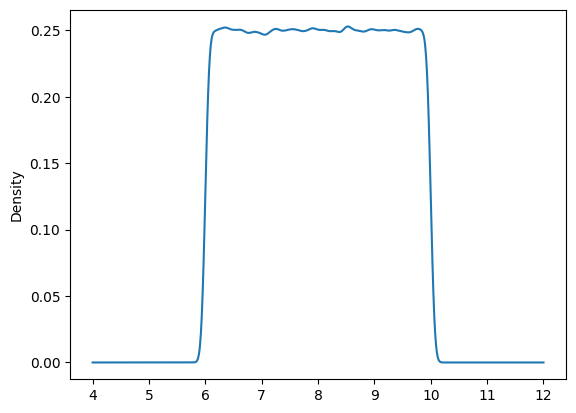

In [123]:
pd.Series(y_train).plot(kind = 'density', bw_method = 0.05)

In [ ]:
pd.Series(y_train).plot(kind = 'density', bw_method = 0.01)

## This dataset dont really good in other regression so we choose the classification

In [49]:
classifier = RandomForestClassifier(
    n_estimators = 100, 
    class_weight = None, # classifier specific
    criterion = 'gini',  # classifier specific
    max_depth = 10, 
    min_samples_split = 2, 
    min_samples_leaf = 1, 
    min_weight_fraction_leaf = 0.0, 
    max_features = 'sqrt', 
    max_leaf_nodes = None, 
    min_impurity_decrease = 0.0, 
    ccp_alpha = 0.0, 
    random_state = 42, 
    bootstrap = True, 
    oob_score = True, 
    max_samples = None,
    warm_start = False, 
    n_jobs = -1, 
    verbose = 0, 
)

In [50]:
y[:10]

0    6.366748
1    6.895413
2    6.964137
3    6.683244
4    6.955717
5    6.764182
6    7.187431
7    6.986734
8    9.161779
9    9.797013
Name: Quality_Score, dtype: Float64

In [51]:
print(y_train.value_counts())

Quality_Score
6.366748    1
7.010882    1
8.256811    1
7.897637    1
6.391233    1
           ..
8.787762    1
7.003216    1
7.757523    1
9.909374    1
9.154174    1
Name: count, Length: 950000, dtype: Int64


In [52]:
label_encoder = LabelEncoder()

y_cat_2 = label_encoder.fit_transform(intervals_2)

In [53]:
X_small.info()

<class 'pandas.core.frame.DataFrame'>
Index: 20000 entries, 919213 to 9011543
Data columns (total 29 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   Batch_ID                      20000 non-null  Int64  
 1   Beer_Style                    20000 non-null  int8   
 2   SKU                           20000 non-null  int8   
 3   Location                      20000 non-null  int8   
 4   Fermentation_Time             20000 non-null  Int64  
 5   Temperature                   20000 non-null  Float64
 6   pH_Level                      20000 non-null  Float64
 7   Gravity                       20000 non-null  Float64
 8   Alcohol_Content               20000 non-null  Float64
 9   Bitterness                    20000 non-null  Int64  
 10  Color                         20000 non-null  Int64  
 11  Volume_Produced               20000 non-null  Int64  
 12  Total_Sales                   20000 non-null  Float64
 13 

In [54]:
%time classifier.fit(X_small, y_cat_2_small)


CPU times: total: 12.5 s
Wall time: 1.71 s


RandomForestClassifier(max_depth=10, n_jobs=-1, oob_score=True, random_state=42)

In [55]:
print(classifier.score(X_small, y_cat_2_small)) # classification accuracy on training set
print(classifier.score(X_valid, y_cat_2_valid)) # classification accuracy on validation set
print(classifier.oob_score_)  

0.855
0.49994
0.5004


In [56]:
classifier.predict_proba(X_valid[:1])[0]

array([0.49586835, 0.50413165])

In [57]:
classifier.predict(X_valid[:1])[0].item()

1

In [58]:
probas_1 = classifier.predict_proba(X_valid)[:, 1]
prob_labels = [int(p > 0.5) for p in probas_1]

pred_labels = classifier.predict(X_valid)

(sum(prob_labels == pred_labels)/len(pred_labels)).item()

1.0

In [59]:
trees = classifier.estimators_
point = X_valid[:1]
preds = np.asarray([tree.predict_proba(point)[0] for tree in trees])

avg = preds.sum(0) 
avg = avg/sum(avg)

print('Tree probabilities:\n', preds)
print('\nAverage probability:\n', avg)

D:\software\Anaconda\envs\EM-Assproject-2024-Zhongjie\Lib\site-packages\sklearn\base.py:486: UserWarning: X has feature names, but DecisionTreeClassifier was fitted without feature names
  warnings.warn(
D:\software\Anaconda\envs\EM-Assproject-2024-Zhongjie\Lib\site-packages\sklearn\base.py:486: UserWarning: X has feature names, but DecisionTreeClassifier was fitted without feature names
  warnings.warn(
D:\software\Anaconda\envs\EM-Assproject-2024-Zhongjie\Lib\site-packages\sklearn\base.py:486: UserWarning: X has feature names, but DecisionTreeClassifier was fitted without feature names
  warnings.warn(
D:\software\Anaconda\envs\EM-Assproject-2024-Zhongjie\Lib\site-packages\sklearn\base.py:486: UserWarning: X has feature names, but DecisionTreeClassifier was fitted without feature names
  warnings.warn(
D:\software\Anaconda\envs\EM-Assproject-2024-Zhongjie\Lib\site-packages\sklearn\base.py:486: UserWarning: X has feature names, but DecisionTreeClassifier was fitted without feature nam

Tree probabilities:
 [[0.52592593 0.47407407]
 [0.45532137 0.54467863]
 [0.60447761 0.39552239]
 [0.48594378 0.51405622]
 [0.48456261 0.51543739]
 [0.4430622  0.5569378 ]
 [0.51039554 0.48960446]
 [0.50970917 0.49029083]
 [0.50823828 0.49176172]
 [0.43368107 0.56631893]
 [0.40222898 0.59777102]
 [0.49138998 0.50861002]
 [0.48552999 0.51447001]
 [0.54681027 0.45318973]
 [0.53028385 0.46971615]
 [0.47972973 0.52027027]
 [0.44633838 0.55366162]
 [0.60808081 0.39191919]
 [0.5801105  0.4198895 ]
 [0.40354767 0.59645233]
 [0.54084967 0.45915033]
 [0.48030093 0.51969907]
 [0.47822721 0.52177279]
 [0.44587353 0.55412647]
 [0.47655942 0.52344058]
 [0.54613807 0.45386193]
 [0.51898281 0.48101719]
 [0.5634119  0.4365881 ]
 [0.57057654 0.42942346]
 [0.62790698 0.37209302]
 [0.49661692 0.50338308]
 [0.47771429 0.52228571]
 [0.42652027 0.57347973]
 [0.50249377 0.49750623]
 [0.5193339  0.4806661 ]
 [0.4507772  0.5492228 ]
 [0.40704739 0.59295261]
 [0.51465416 0.48534584]
 [0.49848841 0.50151159]
 [0.

D:\software\Anaconda\envs\EM-Assproject-2024-Zhongjie\Lib\site-packages\sklearn\base.py:486: UserWarning: X has feature names, but DecisionTreeClassifier was fitted without feature names
  warnings.warn(
D:\software\Anaconda\envs\EM-Assproject-2024-Zhongjie\Lib\site-packages\sklearn\base.py:486: UserWarning: X has feature names, but DecisionTreeClassifier was fitted without feature names
  warnings.warn(
D:\software\Anaconda\envs\EM-Assproject-2024-Zhongjie\Lib\site-packages\sklearn\base.py:486: UserWarning: X has feature names, but DecisionTreeClassifier was fitted without feature names
  warnings.warn(
D:\software\Anaconda\envs\EM-Assproject-2024-Zhongjie\Lib\site-packages\sklearn\base.py:486: UserWarning: X has feature names, but DecisionTreeClassifier was fitted without feature names
  warnings.warn(
D:\software\Anaconda\envs\EM-Assproject-2024-Zhongjie\Lib\site-packages\sklearn\base.py:486: UserWarning: X has feature names, but DecisionTreeClassifier was fitted without feature nam

In [60]:
tree.feature_importances_

array([6.02952116e-02, 2.40803085e-02, 1.49325832e-02, 2.71608051e-02,
       2.36969292e-02, 5.87665245e-02, 4.25595874e-02, 7.20549076e-02,
       5.84495828e-02, 4.91576013e-02, 2.93568106e-02, 5.77252270e-02,
       5.13294336e-02, 7.02260227e-02, 6.03114945e-02, 6.26517583e-02,
       5.88793547e-02, 4.12019062e-03, 1.77375186e-02, 3.50000552e-02,
       2.22577440e-02, 4.61923057e-02, 1.00394103e-04, 2.55294090e-04,
       5.61612094e-04, 5.56891279e-05, 0.00000000e+00, 2.70642105e-06,
       5.20823476e-02])

In [61]:
def specificity_score(y_true, y_predict):
    '''
    Computes the proba that a label is 0 knowing that the prediction is 0
    '''
    y_predict_0  = [(pred, true) for pred, true in zip(y_predict, y_true) if true == 0]
    y_predict_00 = [(pred, true) for pred, true in y_predict_0 if pred == 0]
    specificity  = (0 if len(y_predict_0) == 0 else len(y_predict_00)/len(y_predict_0))
    return specificity

In [62]:
y_predict_valid = classifier.predict(X_valid)

acc = metrics.accuracy_score(y_cat_2_valid, y_predict_valid)
rec = metrics.recall_score(y_cat_2_valid, y_predict_valid)
prc = metrics.precision_score(y_cat_2_valid, y_predict_valid)
spe = specificity_score(y_cat_2_valid, y_predict_valid)
f1  = metrics.f1_score(y_cat_2_valid, y_predict_valid)

print('Accuracy : {:.2f}%'.format(acc*100))
print('Recall : {:.2f}%'.format(rec*100))
print('Precision : {:.2f}%'.format(prc*100))
print('Specificity : {:.2f}%'.format(spe*100))
print('F1-score : {:.2f}%'.format(f1*100))

Accuracy : 49.99%
Recall : 48.00%
Precision : 49.63%
Specificity : 51.96%
F1-score : 48.80%


In [63]:
feat_importance = rf_feat_importance(tree, X_small)
feat_importance[:20]

cols       imp
7                        Gravity  0.072055
13          Brewhouse_Efficiency  0.070226
15      Loss_During_Fermentation  0.062652
14           Loss_During_Brewing  0.060311
0                       Batch_ID  0.060295
16  Loss_During_Bottling_Kegging  0.058879
5                    Temperature  0.058767
8                Alcohol_Content  0.058450
11               Volume_Produced  0.057725
28                  Brew_Elapsed  0.052082
12                   Total_Sales  0.051329
9                     Bitterness  0.049158
21                Brew_Dayofyear  0.046192
6                       pH_Level  0.042560
19                      Brew_Day  0.035000
10                         Color  0.029357
3                       Location  0.027161
1                     Beer_Style  0.024080
4              Fermentation_Time  0.023697
20                Brew_Dayofweek  0.022258

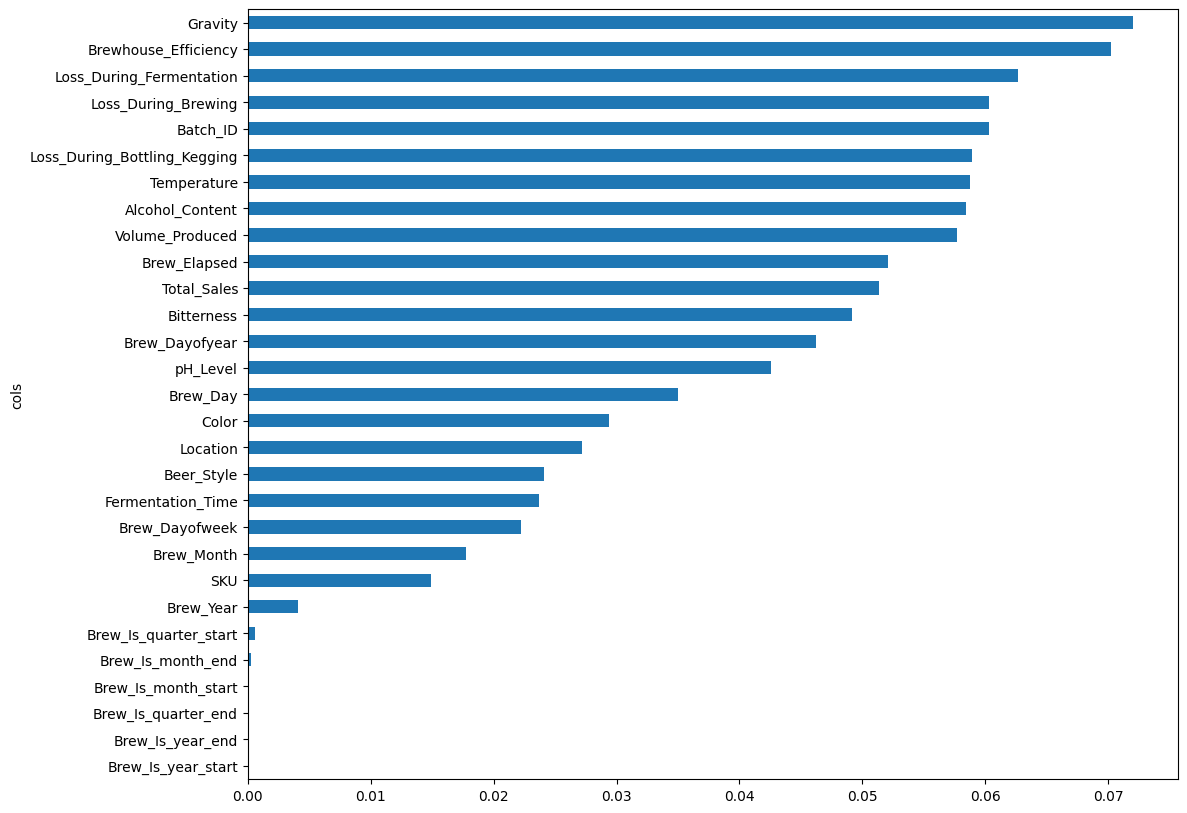

In [64]:
barh = feat_importance[:30].plot('cols', 'imp', 'barh', figsize = (12,10), legend = False)
barh = barh.invert_yaxis()
barh